In [3]:
# 载入pickled数据
import pickle

# TODO: 根据你保存训练和测试数据的路径填写以下内容

training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of a traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.concatenate((y_train, y_valid, y_test))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

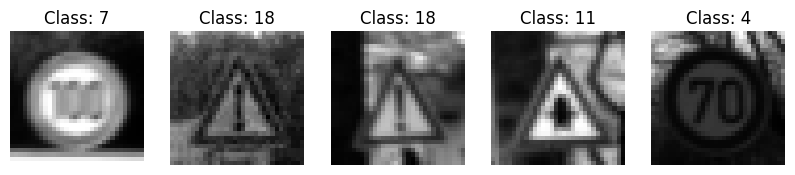

In [6]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from skimage import color

# 首先，对图像进行随机化处理，以确保数据随机性
X_train, y_train = shuffle(X_train, y_train)

# 归一化图像数据
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train.reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)
X_valid_normalized = scaler.transform(X_valid.reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)
X_test_normalized = scaler.transform(X_test.reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)

# 转换图像为灰度图像
X_train_grayscale = color.rgb2gray(X_train_normalized)
X_valid_grayscale = color.rgb2gray(X_valid_normalized)
X_test_grayscale = color.rgb2gray(X_test_normalized)

# 可选：显示灰度图像
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_grayscale[i], cmap='gray')
    plt.title("Class: {}".format(y_train[i]))
    plt.axis('off')

plt.show()


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply convolutional and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the input
        x = x.view(-1, 128 * 4 * 4)
        
        # Apply fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# Instantiate the model
num_classes = 43  # Assuming 43 classes for traffic sign classification
model = SimpleCNN(num_classes)

# Print the model architecture
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=43, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 将数据转换为PyTorch张量
X_train_tensor = torch.from_numpy(X_train_grayscale).unsqueeze(1).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_valid_tensor = torch.from_numpy(X_valid_grayscale).unsqueeze(1).float()
y_valid_tensor = torch.from_numpy(y_valid).long()

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# 实例化模型和定义损失函数、优化器
num_classes = 43
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 10
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 在验证集上评估模型
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{epochs}, Validation Accuracy: {accuracy:.4f}')

# 在测试集上评估模型
X_test_tensor = torch.from_numpy(X_test_grayscale).unsqueeze(1).float()
y_test_tensor = torch.from_numpy(y_test).long()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1/10, Validation Accuracy: 0.7063
Epoch 2/10, Validation Accuracy: 0.8490
Epoch 3/10, Validation Accuracy: 0.8739
Epoch 4/10, Validation Accuracy: 0.8975
Epoch 5/10, Validation Accuracy: 0.8993
Epoch 6/10, Validation Accuracy: 0.9145
Epoch 7/10, Validation Accuracy: 0.9143
Epoch 8/10, Validation Accuracy: 0.9240
Epoch 9/10, Validation Accuracy: 0.9270
Epoch 10/10, Validation Accuracy: 0.9166
Test Accuracy: 0.9213


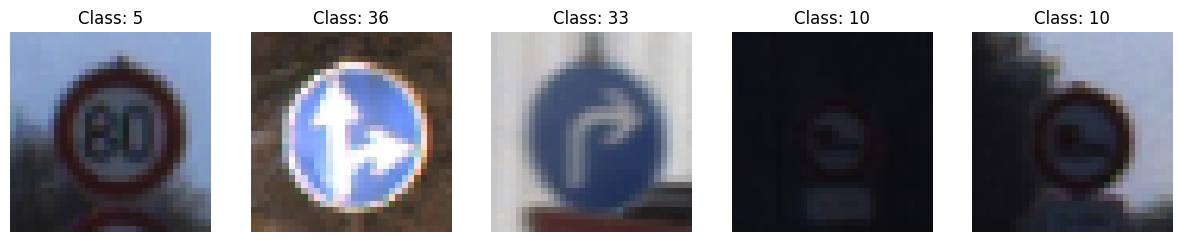

In [35]:
import matplotlib.pyplot as plt
import random

# 从测试集中随机选择一些图像进行可视化
num_images_to_visualize = 5
random_indices = random.sample(range(len(X_test)), num_images_to_visualize)

plt.figure(figsize=(15, 3))

for i, index in enumerate(random_indices):
    plt.subplot(1, num_images_to_visualize, i + 1)
    plt.imshow(X_test[index])
    plt.title(f"Class: {y_test[index]}")
    plt.axis('off')

plt.show()


In [36]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# 将测试集数据转换为PyTorch张量
X_test_tensor = torch.from_numpy(X_test_grayscale).unsqueeze(1).float()
y_test_tensor = torch.from_numpy(y_test).long()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

# 在测试集上进行预测
model.eval()
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.numpy())

# 计算测试集的准确性
test_accuracy = accuracy_score(y_test, all_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# 打印每张图像的预测类别
for i, index in enumerate(random_indices):
    image = X_test[index]
    true_label = y_test[index]
    predicted_label = all_predictions[index]
    print(f"Image {i + 1}: True Class {true_label}, Predicted Class {predicted_label}")

# 如果需要，你也可以将预测结果可视化
# 例如，你可以使用Matplotlib来显示图像及其对应的真实类别和预测类别


Test Accuracy: 0.9213
Image 1: True Class 5, Predicted Class 5
Image 2: True Class 36, Predicted Class 36
Image 3: True Class 33, Predicted Class 33
Image 4: True Class 10, Predicted Class 10
Image 5: True Class 10, Predicted Class 10


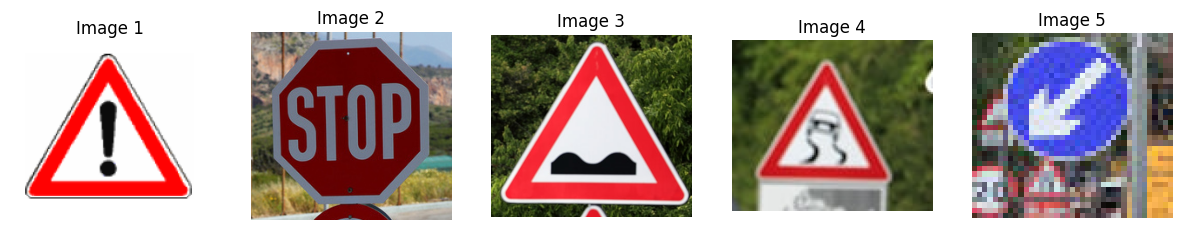

In [39]:
import matplotlib.pyplot as plt
from PIL import Image

# 文件名列表
web_images = [f"{i}.png" for i in range(1, 6)]

# 显示图像
plt.figure(figsize=(15, 3))
for i, img_path in enumerate(web_images):
    plt.subplot(1, 5, i + 1)
    
    # 使用 PIL 加载图像
    img = Image.open(img_path)
    
    # 显示图像
    plt.imshow(img)
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


In [40]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# 定义数据的预处理操作，确保与模型训练时的预处理一致
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# 加载Web上找到的图像数据
web_images = [f"{i}.png" for i in range(1, 6)]
X_web = [transform(Image.open(img)) for img in web_images]
X_web_tensor = torch.stack(X_web)

# 在Web上找到的图像上进行预测
model.eval()
with torch.no_grad():
    outputs_web = model(X_web_tensor)
    probabilities = F.softmax(outputs_web, dim=1)
    top5_probabilities, top5_classes = torch.topk(probabilities, 5, dim=1)

# 打印前五个softmax概率及其对应的类别
for i in range(len(web_images)):
    print(f"\nTop 5 softmax probabilities for Web Image {i + 1} ({web_images[i]}):")
    for j in range(5):
        prob = top5_probabilities[i, j].item()
        class_index = top5_classes[i, j].item()
        print(f"  Probability {j + 1}: {prob:.4f}, Class: {class_index}")



Top 5 softmax probabilities for Web Image 1 (1.png):
  Probability 1: 1.0000, Class: 18
  Probability 2: 0.0000, Class: 26
  Probability 3: 0.0000, Class: 27
  Probability 4: 0.0000, Class: 24
  Probability 5: 0.0000, Class: 25

Top 5 softmax probabilities for Web Image 2 (2.png):
  Probability 1: 0.9975, Class: 14
  Probability 2: 0.0012, Class: 2
  Probability 3: 0.0007, Class: 1
  Probability 4: 0.0003, Class: 4
  Probability 5: 0.0002, Class: 13

Top 5 softmax probabilities for Web Image 3 (3.png):
  Probability 1: 1.0000, Class: 22
  Probability 2: 0.0000, Class: 26
  Probability 3: 0.0000, Class: 29
  Probability 4: 0.0000, Class: 18
  Probability 5: 0.0000, Class: 25

Top 5 softmax probabilities for Web Image 4 (4.png):
  Probability 1: 0.3657, Class: 29
  Probability 2: 0.2654, Class: 24
  Probability 3: 0.2487, Class: 18
  Probability 4: 0.0742, Class: 22
  Probability 5: 0.0379, Class: 26

Top 5 softmax probabilities for Web Image 5 (5.png):
  Probability 1: 0.4091, Class: 3

In [146]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

# 实际的类别标签（根据你的数据）
true_labels_web = [18, 14, 22, 23,  39]  # 替换为每个图像的实际类别

# 预测标签
predicted_labels_web = top5_classes[:, 0]  # 取每个样本的Top-1预测标签

# 计算准确率
accuracy_web = accuracy_score(true_labels_web, predicted_labels_web.numpy())
print(f"Accuracy for the 5 new images: {accuracy_web * 100:.2f}%")


Accuracy for the 5 new images: 60.00%


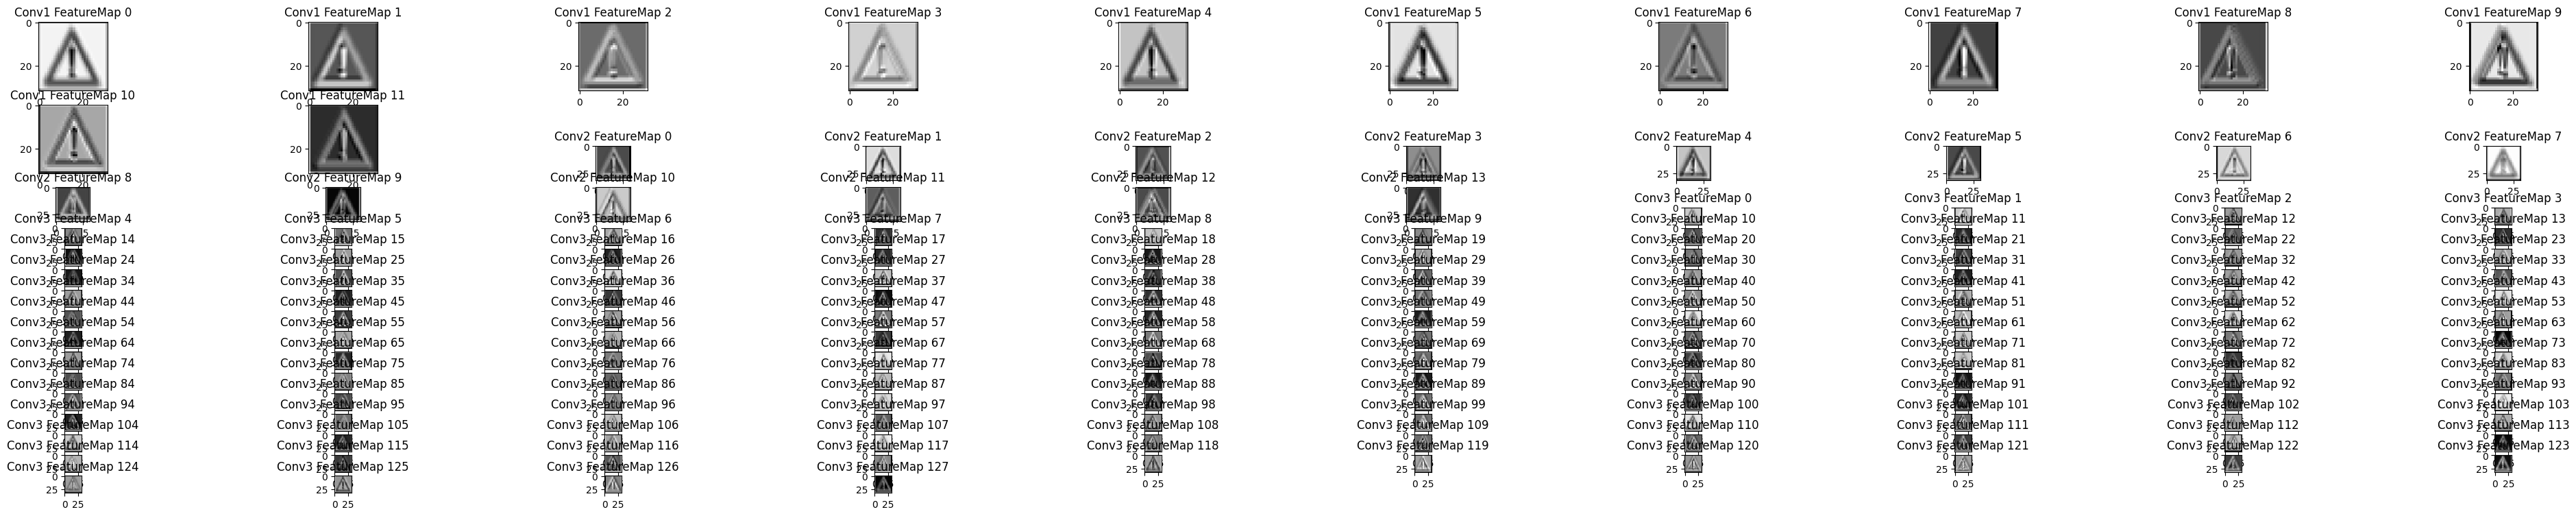

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def outputFeatureMap(image_input, model, activation_min=-1, activation_max=-1, plt_num=1):
    # 设置模型为评估模式
    model.eval()

    # 获取模型的卷积层
    conv1 = model.conv1
    conv2 = model.conv2
    conv3 = model.conv3

    # 转换输入图像为 PyTorch 张量
    image_input = torch.from_numpy(image_input).float()

    # Forward pass 获取激活
    with torch.no_grad():
        activation1 = conv1(image_input)
        activation2 = conv2(activation1)
        activation3 = conv3(activation2)

    # 可视化特征图
    featuremaps1 = activation1.size(1)
    featuremaps2 = activation2.size(1)
    featuremaps3 = activation3.size(1)

    plt.figure(plt_num, figsize=(50, 50))

    # 输出 Conv1 特征图
    for featuremap in range(featuremaps1):
        plt.subplot(featuremaps1, 10, featuremap+1)
        plt.title(f'Conv1 FeatureMap {featuremap}')
        plt.imshow(activation1[0, featuremap].numpy(), interpolation="nearest", cmap="gray")


    # 输出 Conv2 特征图
    for featuremap in range(featuremaps2):
        plt.subplot(featuremaps2, 10, featuremap+1+featuremaps1)
        plt.title(f'Conv2 FeatureMap {featuremap}')
        plt.imshow(activation2[0, featuremap].numpy(), interpolation="nearest", cmap="gray")

    
    # 输出 Conv3 特征图
    for featuremap in range(featuremaps3):
        plt.subplot(featuremaps3, 10, featuremap+1+featuremaps1+featuremaps2)
        plt.title(f'Conv3 FeatureMap {featuremap}')
        plt.imshow(activation3[0, featuremap].numpy(), interpolation="nearest", cmap="gray")




# 加载图片
image_path = "1.png"  # 图片路径，根据你的实际路径进行修改
image = Image.open(image_path)

# 调整图像大小为模型期望的输入尺寸（32x32）
image = image.resize((32, 32))

image_array = np.array(image)

# 如果图像的通道数不是3，调整通道数为3
if image_array.shape[2] != 3:
    image_array = np.stack((image_array,) * 3, axis=-1)
# 将图像数据归一化
X_test_normalized = image_array / 255.0  # 假设图像的像素值在 [0, 255] 范围内

# 添加批次维度
X_test_normalized = np.expand_dims(X_test_normalized, axis=0)

# 调整通道顺序
X_test_normalized = X_test_normalized.transpose((0, 3, 1, 2))

# Instantiate the model with 1 input channel
num_classes = 42
model = SimpleCNN(num_classes)

# Convert input data to grayscale
X_test_grayscale = np.mean(X_test_normalized, axis=1, keepdims=True)

# Visualize feature maps
outputFeatureMap(X_test_grayscale, model, plt_num=1)